<a href="https://colab.research.google.com/github/mtayyabali/eye-tracking-project/blob/master/Project_Eye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Extract zip file
import zipfile
with zipfile.ZipFile('/content/csvFiles.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data2/')

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set some constants
FOCUS_THRESHOLD = 0.5

# Define some necessary functions
def load_data(folder_path):
    data = {}
    for traffic in ['High Traffic', 'Low Traffic']:
        for speed in ['High Speed', 'Low Speed']:
            scenario = f'{traffic}/{speed}'
            data[scenario] = {}
            for participant in range(1, 5):
                file_path = f'{folder_path}/{scenario}/participant{participant}.csv'
                data[scenario][participant] = pd.read_csv(file_path)
                # Convert gaze_timestamp to datetime
                data[scenario][participant]['gaze_timestamp'] = pd.to_datetime(data[scenario][participant]['gaze_timestamp'])
    return data

def calculate_focus(df, center_threshold=0.1):
    center_low = FOCUS_THRESHOLD - center_threshold
    center_high = FOCUS_THRESHOLD + center_threshold

    df['focus'] = 'centre'
    df.loc[df['norm_pos_x'] < center_low, 'focus'] = 'left'
    df.loc[df['norm_pos_x'] > center_high, 'focus'] = 'right'

    return df

def plot_focus_count(data):
    count_data = []
    for scenario, participants in data.items():
        for participant, df in participants.items():
            count_data.append(df['focus'].value_counts().rename('count').reset_index().assign(scenario=scenario, participant=participant))
    count_df = pd.concat(count_data)

    print(count_df)  # print the dataframe

    focus_order = ['centre', 'left', 'right']  # Specify the order of focus categories

    for participant in count_df['participant'].unique():
        plt.figure(figsize=(5, 5))
        df = count_df[count_df['participant'] == participant]
        sns.barplot(data=df, x='index', y='count', hue='scenario', order=focus_order)  # Specify the order in the barplot
        plt.title(f"Focus Count - Participant {participant}")
        plt.xlabel("Focus")
        plt.ylabel("Count")
        plt.legend(title="Scenario")
        plt.show()

def plot_focus_duration(data):
    duration_data = []
    for scenario, participants in data.items():
        for participant, df in participants.items():
            df = df.sort_values(by='gaze_timestamp')  # Ensure data is in correct order
            df['duration'] = df['gaze_timestamp'].diff()  # This will give the difference in seconds
            df = df.dropna(subset=['duration'])  # Drop rows with NaN duration
            df['duration'] = pd.to_numeric(df['duration'], errors='coerce')  # Convert duration to numeric
            duration_data.append(df.groupby('focus')['duration'].sum().rename('duration').reset_index().assign(scenario=scenario, participant=participant))

    duration_df = pd.concat(duration_data)

    # Print out the focus duration data
    print(duration_df)

    # Iterate through each participant to generate individual plots
    for participant in duration_df['participant'].unique():
        plt.figure(figsize=(10, 10))
        sns.barplot(data=duration_df[duration_df['participant'] == participant], x='focus', y='duration', hue='scenario')
        plt.title(f'Focus Duration for Participant {participant}')
        plt.show()


def plot_average_focus(data):
    average_coordinates = []
    for scenario, participants in data.items():
        for participant, df in participants.items():
            mean_x = df['norm_pos_x'].mean()
            mean_y = df['norm_pos_y'].mean()
            average_coordinates.append([participant, scenario, mean_x, mean_y])

    average_df = pd.DataFrame(average_coordinates, columns=['participant', 'scenario', 'mean_x', 'mean_y'])

    # Print out the average coordinates
    print(average_df)

    for participant in average_df['participant'].unique():
        plt.figure(figsize=(5, 5))
        df = average_df[average_df['participant'] == participant]
        sns.scatterplot(data=df, x='mean_x', y='mean_y', hue='scenario', s=100)
        plt.title(f"Average Focus Coordinates - Participant {participant}")
        plt.xlabel("Average X Coordinate")
        plt.ylabel("Average Y Coordinate")
        plt.legend(title="Scenario")
        plt.grid(True)
        plt.show()


In [4]:
# Load data
data_folder_path = "/content/data2/csvFiles/"
data = load_data(data_folder_path)

   High Traffic/High Speed  High Traffic/Low Speed  Low Traffic/High Speed  \
1                    69927                  125762                   88017   
2                    63828                   79258                   17068   
3                    75222                   74772                   91606   
4                    80102                  113359                   33605   

   Low Traffic/Low Speed  
1                 158922  
2                  65934  
3                  68749  
4                  36460  
Average focus on centre: 77661.9375


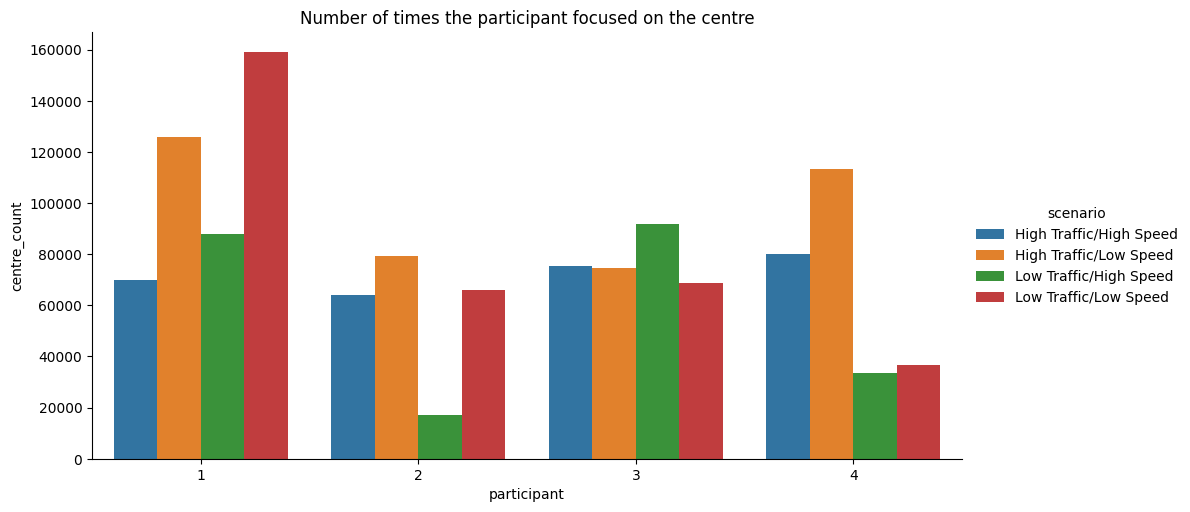

In [5]:
# Calculate focus
for scenario, participants in data.items():
    for participant, df in participants.items():
        df.dropna(axis='columns', inplace=True)
        df = calculate_focus(df)

# 1. How many times the participant focused on the centre? Average?
centre_focus_counts = {scenario: {participant: df['focus'].value_counts().get('centre', 0) for participant, df in participants.items()} for scenario, participants in data.items()}
centre_focus_counts_df = pd.DataFrame(centre_focus_counts)
print(centre_focus_counts_df)
print("Average focus on centre:", centre_focus_counts_df.mean().mean())

centre_focus_counts_df = pd.DataFrame(centre_focus_counts).reset_index().melt(id_vars='index', var_name='scenario', value_name='centre_count')
centre_focus_counts_df.rename(columns={'index':'participant'}, inplace=True)
sns.catplot(data=centre_focus_counts_df, x='participant', y='centre_count', hue='scenario', kind='bar', height=5, aspect=2)
plt.title('Number of times the participant focused on the centre')
plt.show()

   High Traffic/High Speed  High Traffic/Low Speed  Low Traffic/High Speed  \
1                 1.082092                1.006925                0.928136   
2                 0.663619                0.776416                0.528080   
3                 0.655094                0.582963                1.248166   
4                 1.049842                1.010522                0.958029   

   Low Traffic/Low Speed  
1               0.864022  
2               0.471141  
3               0.994271  
4               0.937541  
Focus difference in scenarios:    High Traffic/High Speed  High Traffic/Low Speed  Low Traffic/High Speed  \
1                      NaN               -0.075166               -0.078789   
2                      NaN                0.112798               -0.248337   
3                      NaN               -0.072131                0.665203   
4                      NaN               -0.039320               -0.052493   

   Low Traffic/Low Speed  
1              -0.064114 

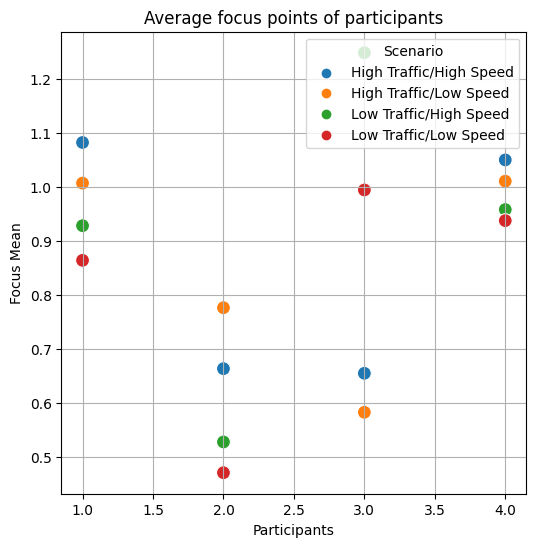

In [6]:
# 2. Difference of Focus points average in high traffic and low traffic with high and low speed scenarios.
focus_means = {scenario: {participant: df['focus'].map({'left': 0, 'right': 2, 'centre': 1}).mean() for participant, df in participants.items()} for scenario, participants in data.items()}
focus_means_df = pd.DataFrame(focus_means)
print(focus_means_df)
print("Focus difference in scenarios:", focus_means_df.diff(axis=1))

focus_means_df = pd.DataFrame(focus_means).reset_index().melt(id_vars='index', var_name='scenario', value_name='focus_mean')
focus_means_df.rename(columns={'index':'participant'}, inplace=True)

# Print the melted dataframe
print(focus_means_df)

# sns.catplot(data=focus_means_df, x='participant', y='focus_mean', hue='scenario', kind='bar', height=5, aspect=2)
# plt.title('Average focus points of participants')
# plt.show()

plt.figure(figsize=(6, 6))
sns.scatterplot(data=focus_means_df, x='participant', y='focus_mean', hue='scenario', s=100)
plt.title('Average focus points of participants')
plt.xlabel("Participants")
plt.ylabel("Focus Mean")
plt.legend(title="Scenario")
plt.grid(True)
plt.show()

                   scenario  participant  level_2  focus_mean  focus_std
0   High Traffic/High Speed            1        0    1.082092   0.616684
1   High Traffic/High Speed            2        0    0.663619   0.676095
2   High Traffic/High Speed            3        0    0.655094   0.565154
3   High Traffic/High Speed            4        0    1.049842   0.602071
4    High Traffic/Low Speed            1        0    1.006925   0.567146
5    High Traffic/Low Speed            2        0    0.776416   0.664144
6    High Traffic/Low Speed            3        0    0.582963   0.598343
7    High Traffic/Low Speed            4        0    1.010522   0.631666
8    Low Traffic/High Speed            1        0    0.928136   0.540693
9    Low Traffic/High Speed            2        0    0.528080   0.654302
10   Low Traffic/High Speed            3        0    1.248166   0.527421
11   Low Traffic/High Speed            4        0    0.958029   0.581045
12    Low Traffic/Low Speed            1        0  

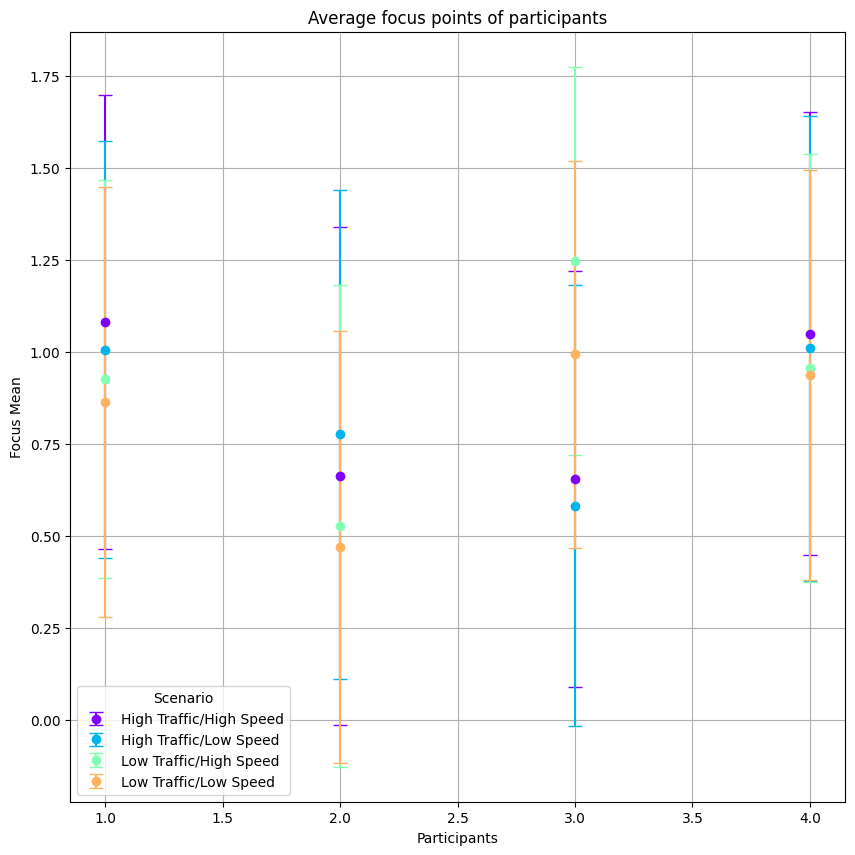

In [7]:
focus_stats = {
    scenario: {
        participant: {
            'focus_mean': df['focus'].map({'left': 0, 'centre': 1, 'right': 2}).mean(),
            'focus_std': df['focus'].map({'left': 0, 'centre': 1, 'right': 2}).std()
        } for participant, df in participants.items()
    } for scenario, participants in data.items()
}

focus_stats_df = pd.concat({(i, j): pd.DataFrame(participant_stats, index=[0])
                            for i, scenario in focus_stats.items()
                            for j, participant_stats in scenario.items()},
                           axis=0)

focus_stats_df = focus_stats_df.reset_index().rename(columns={'level_0': 'scenario', 'level_1': 'participant'})

# Print out the focus statistics dataframe
print(focus_stats_df)

focus_means = focus_stats_df['focus_mean']
focus_stds = focus_stats_df['focus_std']

plt.figure(figsize=(10, 10))

# create a color dictionary for each unique scenario
colors = {scenario: plt.cm.rainbow(i/len(focus_stats_df['scenario'].unique()))
          for i, scenario in enumerate(focus_stats_df['scenario'].unique())}

# plot points with error bars
for i in range(len(focus_stats_df)):
    plt.errorbar(focus_stats_df['participant'].iloc[i],
                 focus_means[i],
                 yerr=focus_stds[i],
                 fmt='o',
                 capsize=5,
                 color=colors[focus_stats_df['scenario'].iloc[i]],
                 label=focus_stats_df['scenario'].iloc[i])

# handle duplicates in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Scenario")

plt.title('Average focus points of participants')
plt.xlabel("Participants")
plt.ylabel("Focus Mean")
plt.grid(True)
plt.show()

    focus  duration                 scenario  participant
0  centre       361  High Traffic/High Speed            1
1    left        87  High Traffic/High Speed            1
2   right       127  High Traffic/High Speed            1
0  centre       311  High Traffic/High Speed            2
1    left       349  High Traffic/High Speed            2
2   right        90  High Traffic/High Speed            2
0  centre       375  High Traffic/High Speed            3
1    left       267  High Traffic/High Speed            3
2   right        32  High Traffic/High Speed            3
0  centre       400  High Traffic/High Speed            4
1    left       106  High Traffic/High Speed            4
2   right       132  High Traffic/High Speed            4
0  centre       638   High Traffic/Low Speed            1
1    left       148   High Traffic/Low Speed            1
2   right       153   High Traffic/Low Speed            1
0  centre       409   High Traffic/Low Speed            2
1    left     

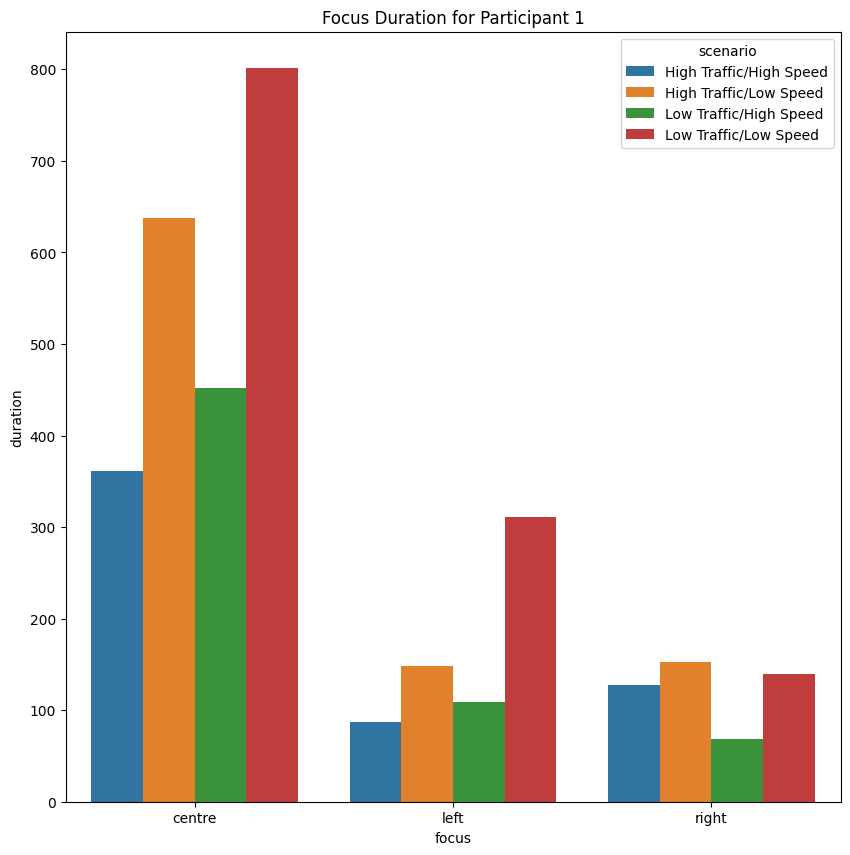

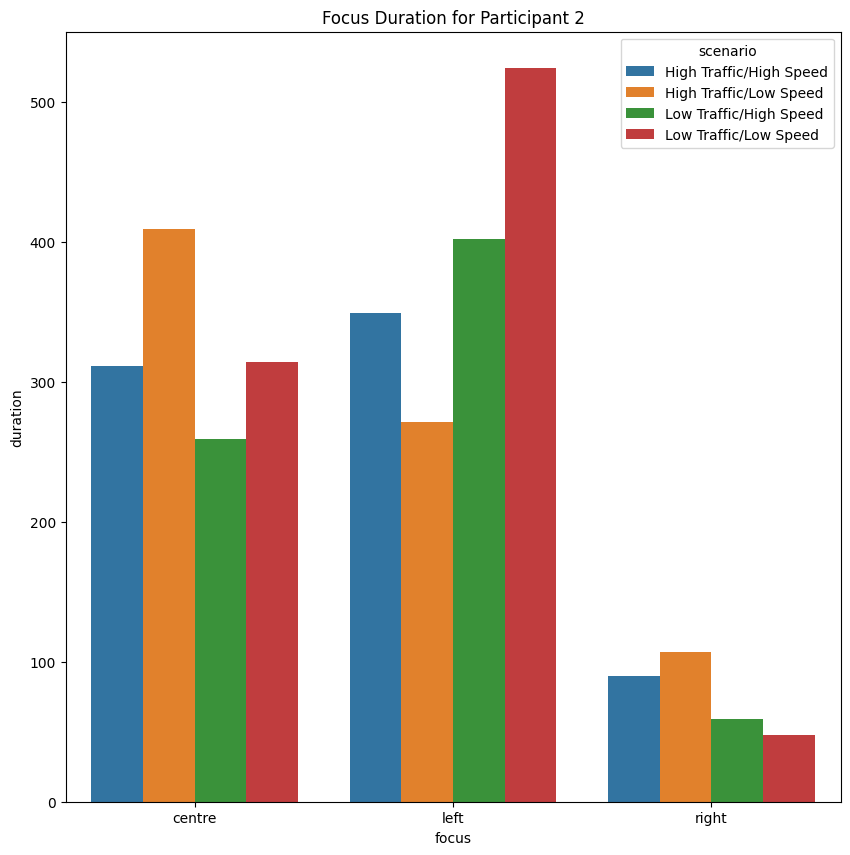

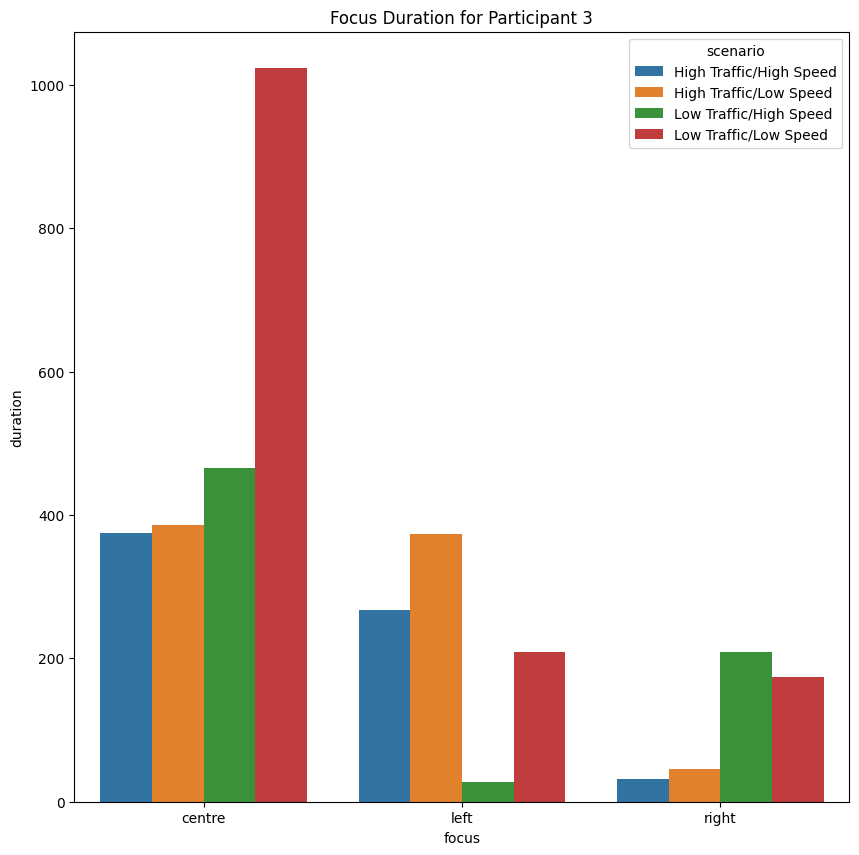

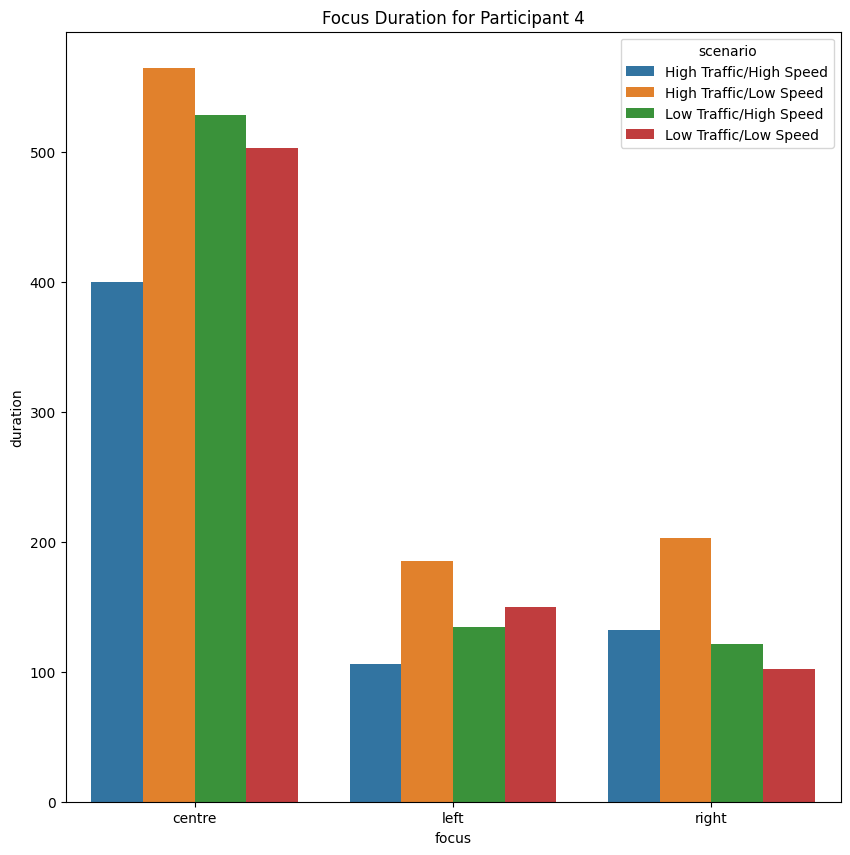

In [10]:
# 3. How much time did participant spent on a certain area of focus (centre, left, right) by using gaze_timestamp?
plot_focus_duration(data)

    index   count                 scenario  participant
0  centre   69927  High Traffic/High Speed            1
1   right   26759  High Traffic/High Speed            1
2    left   17394  High Traffic/High Speed            1
0    left   67329  High Traffic/High Speed            2
1  centre   63828  High Traffic/High Speed            2
2   right   17368  High Traffic/High Speed            2
0  centre   75222  High Traffic/High Speed            3
1    left   52452  High Traffic/High Speed            3
2   right    6258  High Traffic/High Speed            3
0  centre   80102  High Traffic/High Speed            4
1   right   26162  High Traffic/High Speed            4
2    left   19875  High Traffic/High Speed            4
0  centre  125762   High Traffic/Low Speed            1
1   right   30465   High Traffic/Low Speed            1
2    left   29181   High Traffic/Low Speed            1
0  centre   79258   High Traffic/Low Speed            2
1    left   55649   High Traffic/Low Speed      

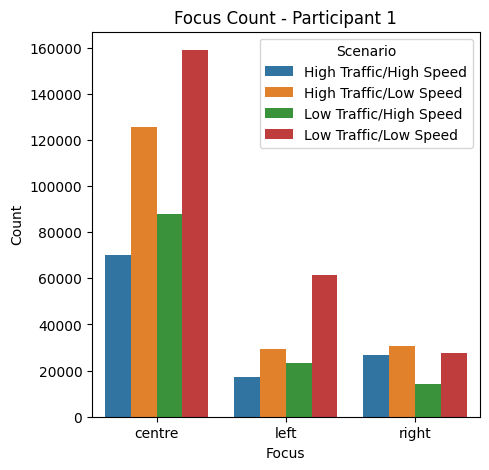

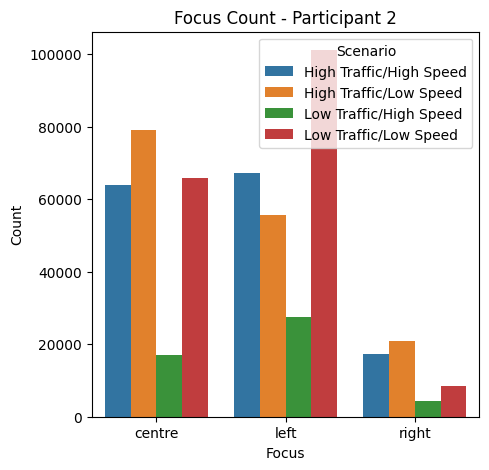

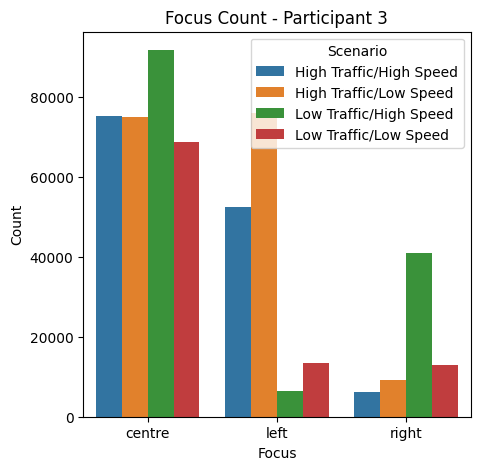

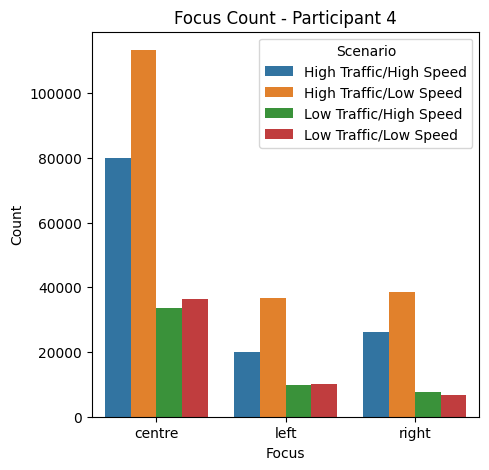

In [14]:
# 4. How much frequency did participant spent on a certain area of focus (centre, left, right)?
plot_focus_count(data)


Participant 1 in scenario High Traffic/High Speed focus during journey:
journey_period  focus 
start           centre    23001
                right      9068
                left       6026
middle          centre    25602
                right      8635
                left       3961
end             centre    21324
                right      9056
                left       7407
Name: focus, dtype: int64

Count of focus points by journey period and focus type:
journey_period  focus 
start           centre    23001
                left       6026
                right      9068
middle          centre    25602
                left       3961
                right      8635
end             centre    21324
                left       7407
                right      9056
Name: count, dtype: int64

Participant 2 in scenario High Traffic/High Speed focus during journey:
journey_period  focus 
start           left      24921
                centre    19102
                right      5674
midd

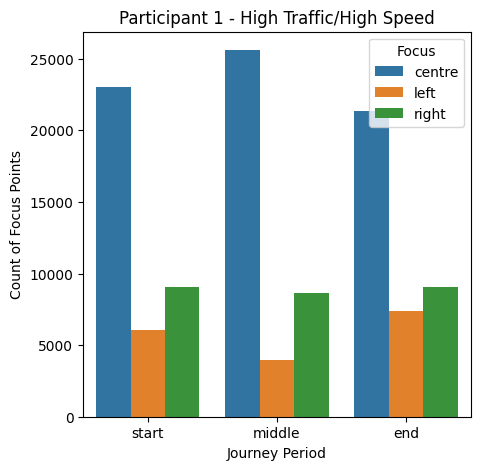

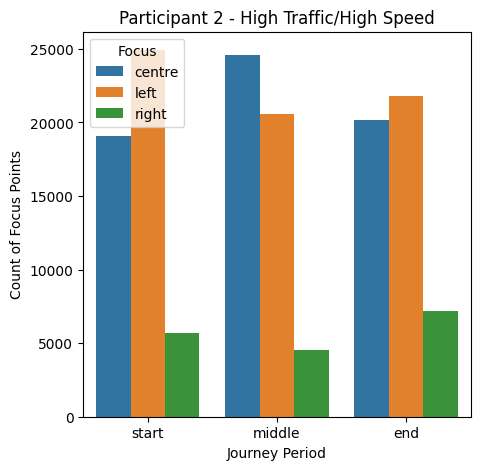

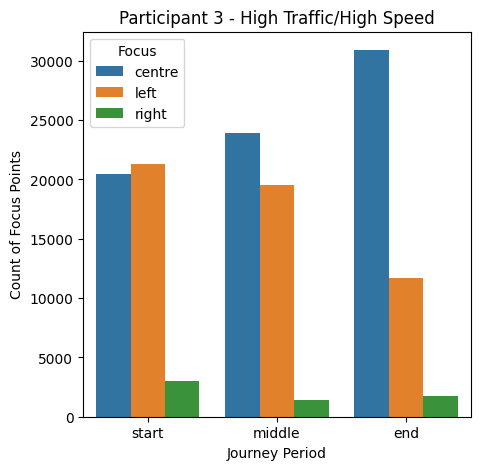

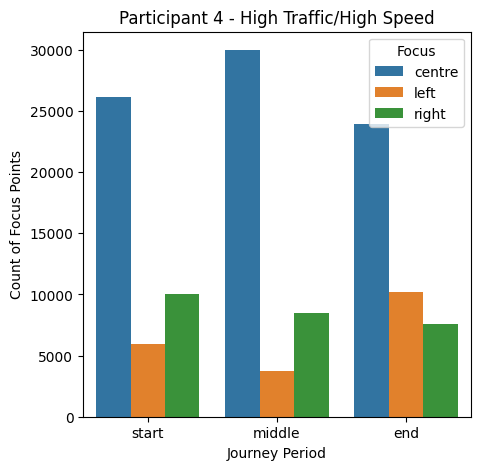

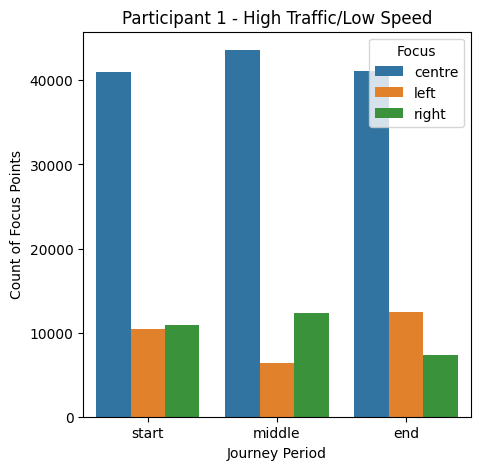

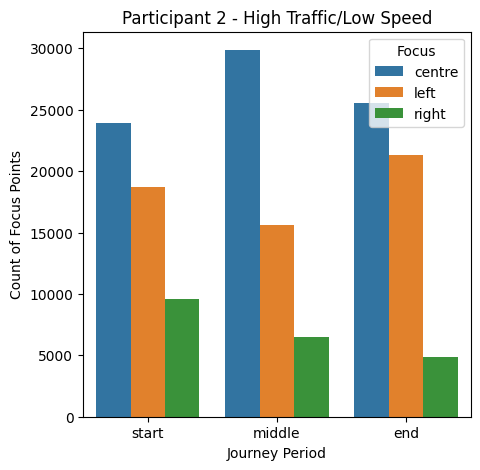

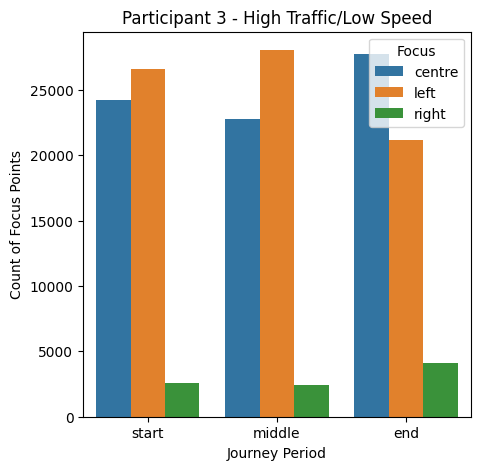

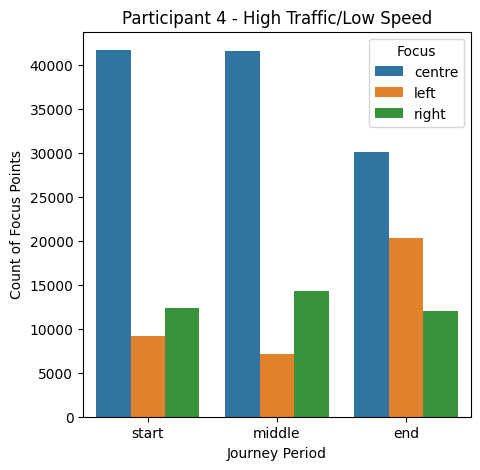

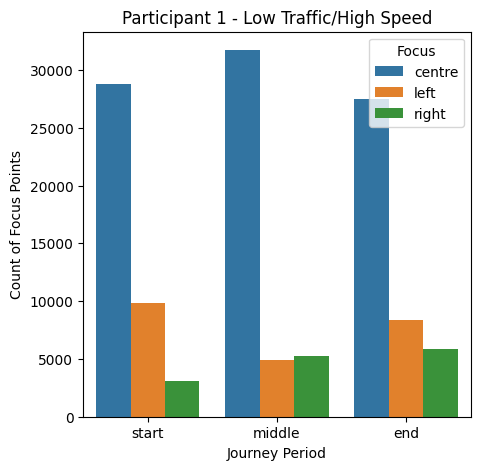

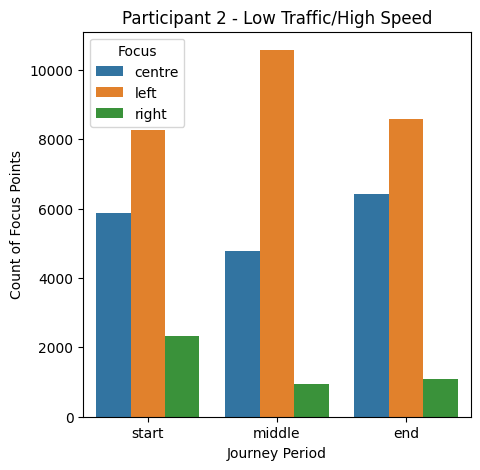

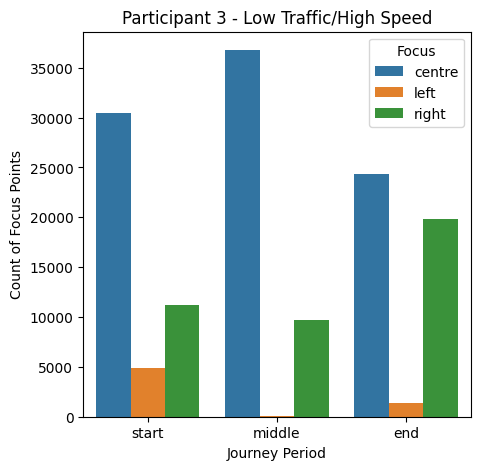

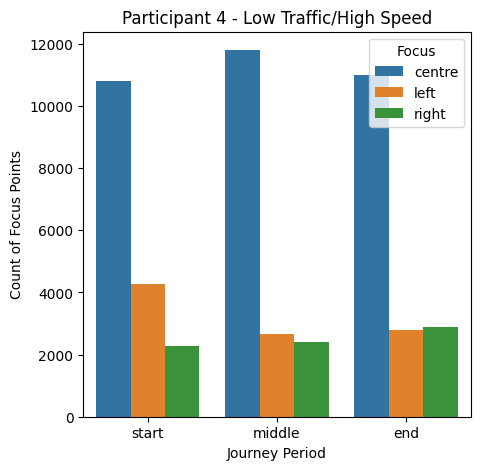

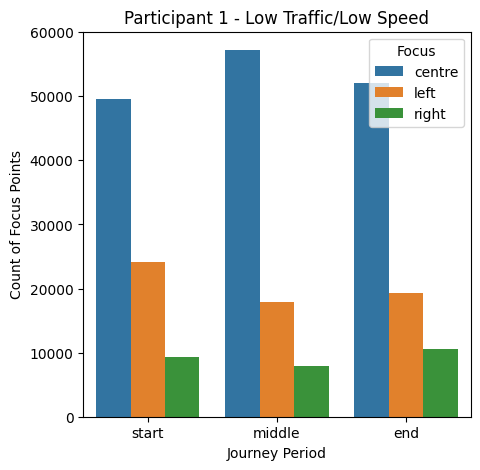

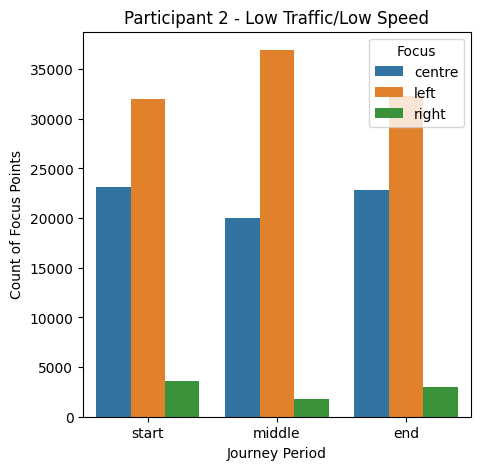

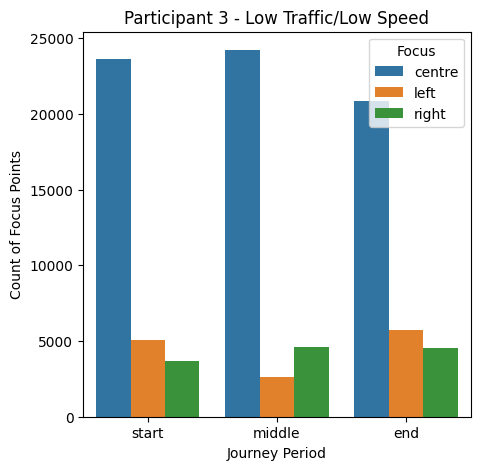

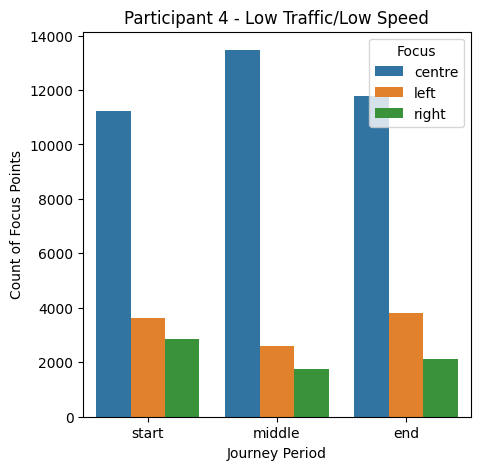

In [16]:
# 5. Where did the participant focused more on the start of the journey, middle and end of the journey by using gaze_timestamp?
journey_data = []
for scenario, participants in data.items():
    for participant, df in participants.items():
        df['journey_period'] = pd.cut(df['gaze_timestamp'], bins=3, labels=['start', 'middle', 'end'])
        print(f"\nParticipant {participant} in scenario {scenario} focus during journey:")
        print(df.groupby('journey_period')['focus'].value_counts())
        journey_series = df.groupby(['journey_period', 'focus']).size().rename('count')
        print("\nCount of focus points by journey period and focus type:")
        print(journey_series)
        journey_data.append(journey_series.reset_index().assign(scenario=scenario, participant=participant))

journey_df = pd.concat(journey_data)

for scenario in journey_df['scenario'].unique():
    for participant in journey_df['participant'].unique():
        plt.figure(figsize=(5, 5))  # Create a new figure for each plot
        df = journey_df[(journey_df['scenario'] == scenario) & (journey_df['participant'] == participant)]
        sns.barplot(data=df, x='journey_period', y='count', hue='focus')
        plt.title(f"Participant {participant} - {scenario}")
        plt.xlabel("Journey Period")
        plt.ylabel("Count of Focus Points")
        plt.legend(title="Focus")
        plt.show()



Journey DataFrame before aggregation:
   journey_period   focus  count                 scenario  participant
0           start  centre  23001  High Traffic/High Speed            1
1           start    left   6026  High Traffic/High Speed            1
2           start   right   9068  High Traffic/High Speed            1
3          middle  centre  25602  High Traffic/High Speed            1
4          middle    left   3961  High Traffic/High Speed            1
..            ...     ...    ...                      ...          ...
4          middle    left   2594    Low Traffic/Low Speed            4
5          middle   right   1741    Low Traffic/Low Speed            4
6             end  centre  11763    Low Traffic/Low Speed            4
7             end    left   3803    Low Traffic/Low Speed            4
8             end   right   2104    Low Traffic/Low Speed            4

[144 rows x 5 columns]

Grouped Journey DataFrame after aggregation:
                   scenario journey_per

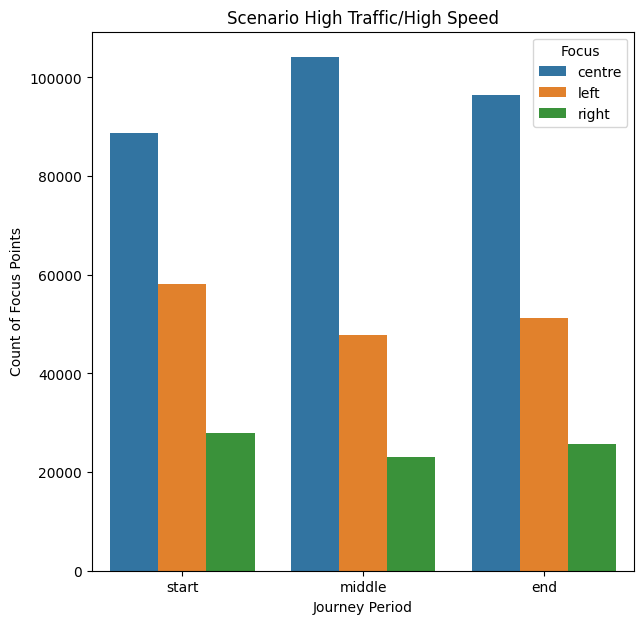


Data for scenario High Traffic/Low Speed:
                  scenario journey_period   focus   count  participant
9   High Traffic/Low Speed          start  centre  130835           10
10  High Traffic/Low Speed          start    left   64897           10
11  High Traffic/Low Speed          start   right   35352           10
12  High Traffic/Low Speed         middle  centre  137878           10
13  High Traffic/Low Speed         middle    left   57214           10
14  High Traffic/Low Speed         middle   right   35461           10
15  High Traffic/Low Speed            end  centre  124438           10
16  High Traffic/Low Speed            end    left   75170           10
17  High Traffic/Low Speed            end   right   28297           10


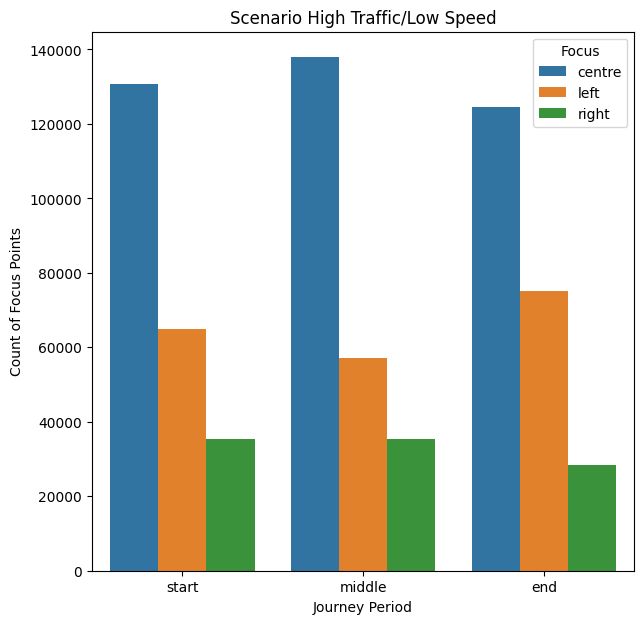


Data for scenario Low Traffic/High Speed:
                  scenario journey_period   focus  count  participant
18  Low Traffic/High Speed          start  centre  75952           10
19  Low Traffic/High Speed          start    left  27325           10
20  Low Traffic/High Speed          start   right  18903           10
21  Low Traffic/High Speed         middle  centre  85098           10
22  Low Traffic/High Speed         middle    left  18142           10
23  Low Traffic/High Speed         middle   right  18272           10
24  Low Traffic/High Speed            end  centre  69246           10
25  Low Traffic/High Speed            end    left  21165           10
26  Low Traffic/High Speed            end   right  29683           10


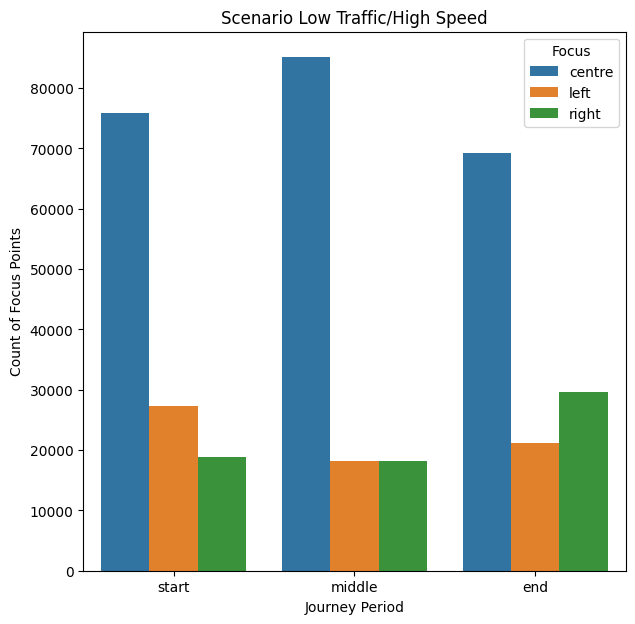


Data for scenario Low Traffic/Low Speed:
                 scenario journey_period   focus   count  participant
27  Low Traffic/Low Speed          start  centre  107694           10
28  Low Traffic/Low Speed          start    left   64875           10
29  Low Traffic/Low Speed          start   right   19476           10
30  Low Traffic/Low Speed         middle  centre  114893           10
31  Low Traffic/Low Speed         middle    left   60021           10
32  Low Traffic/Low Speed         middle   right   16065           10
33  Low Traffic/Low Speed            end  centre  107478           10
34  Low Traffic/Low Speed            end    left   61162           10
35  Low Traffic/Low Speed            end   right   20103           10


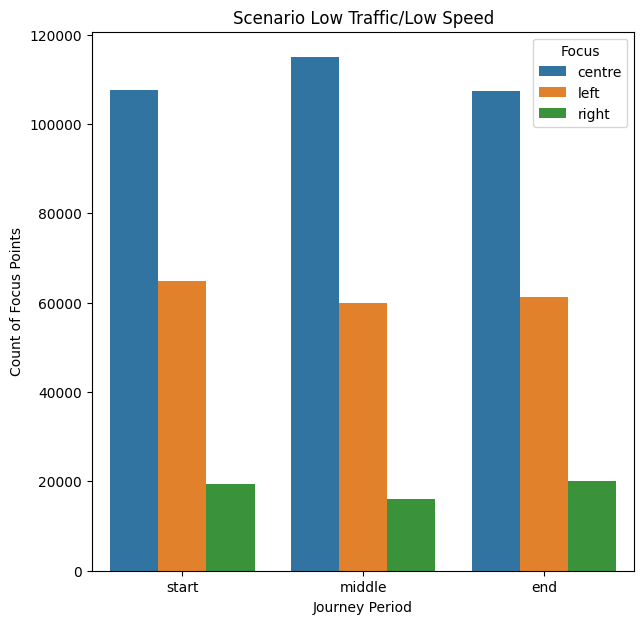

In [19]:
# 5. Where did the participant focused more on the start of the journey, middle and end of the journey by using gaze_timestamp?
journey_data = []
for scenario, participants in data.items():
    for participant, df in participants.items():
        df['journey_period'] = pd.cut(df['gaze_timestamp'], bins=3, labels=['start', 'middle', 'end'])
        journey_series = df.groupby(['journey_period', 'focus']).size().rename('count')
        journey_data.append(journey_series.reset_index().assign(scenario=scenario, participant=participant))

journey_df = pd.concat(journey_data)
print("\nJourney DataFrame before aggregation:")
print(journey_df)

# Group by scenario and journey period, aggregating focus count
grouped_journey_df = journey_df.groupby(['scenario', 'journey_period', 'focus']).sum('count').reset_index()

print("\nGrouped Journey DataFrame after aggregation:")
print(grouped_journey_df)

for scenario in grouped_journey_df['scenario'].unique():
    plt.figure(figsize=(7, 7))  # Create a new figure for each plot
    df = grouped_journey_df[grouped_journey_df['scenario'] == scenario]
    print(f"\nData for scenario {scenario}:")
    print(df)
    sns.barplot(data=df, x='journey_period', y='count', hue='focus')
    plt.title(f"Scenario {scenario}")
    plt.xlabel("Journey Period")
    plt.ylabel("Count of Focus Points")
    plt.legend(title="Focus")
    plt.show()


    participant                 scenario    mean_x    mean_y
0             1  High Traffic/High Speed  0.525985  0.541814
1             2  High Traffic/High Speed  0.420397  0.570599
2             3  High Traffic/High Speed  0.426531  0.581249
3             4  High Traffic/High Speed  0.519141  0.550019
4             1   High Traffic/Low Speed  0.502394  0.553922
5             2   High Traffic/Low Speed  0.442483  0.571926
6             3   High Traffic/Low Speed  0.411131  0.571158
7             4   High Traffic/Low Speed  0.498993  0.542195
8             1   Low Traffic/High Speed  0.476788  0.532519
9             2   Low Traffic/High Speed  0.396282  0.536293
10            3   Low Traffic/High Speed  0.560049  0.590786
11            4   Low Traffic/High Speed  0.491082  0.517322
12            1    Low Traffic/Low Speed  0.462561  0.524927
13            2    Low Traffic/Low Speed  0.395249  0.544766
14            3    Low Traffic/Low Speed  0.501854  0.420674
15            4    Low T

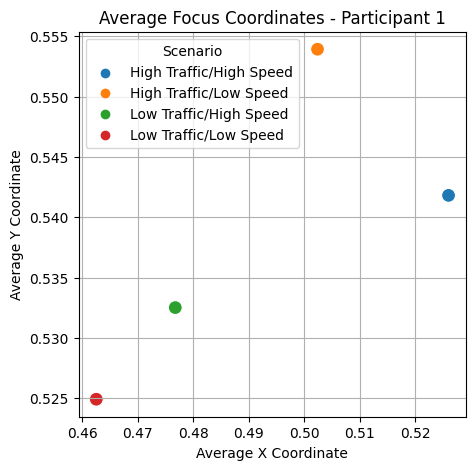

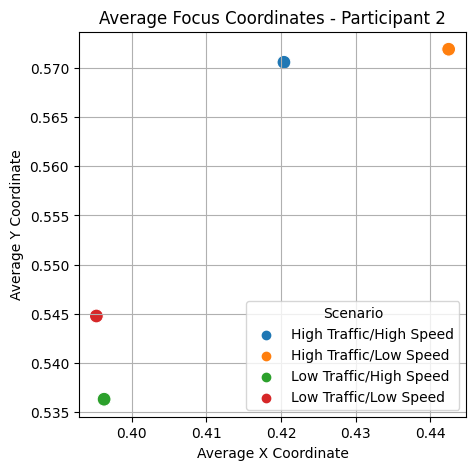

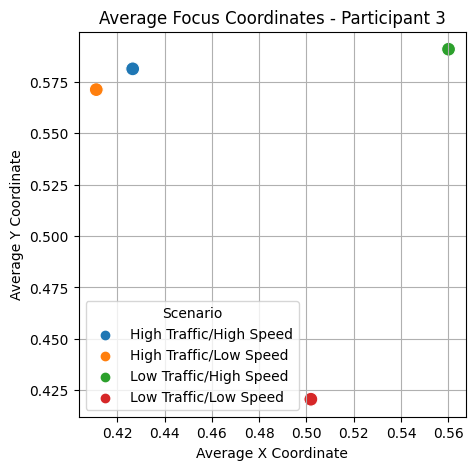

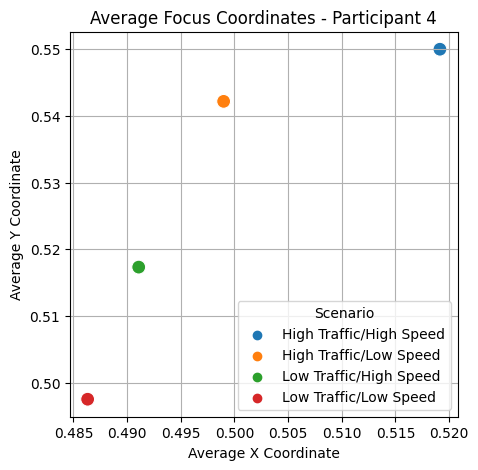

In [23]:
# 6. What is the average focus coordinates of participant?
plot_average_focus(data)